In [1]:
# import libraries

import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

2026-02-19 07:31:09.319554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771486269.835473      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771486269.939821      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771486270.933382      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771486270.933436      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771486270.933442      23 computation_placer.cc:177] computation placer alr

In [2]:
DATA_DIR = "/kaggle/input/datasets/lordtesla77/petimages1/Files/PetImages"

data_dir_dogs = os.path.join(DATA_DIR ,'Dog')
data_dir_cats = os.path.join(DATA_DIR , 'Cat')

print(f"There are {len(os.listdir(data_dir_dogs))} images of dogs.")
print(f"There are {len(os.listdir(data_dir_cats))} images of cats.")

There are 11211 images of dogs.
There are 11223 images of cats.


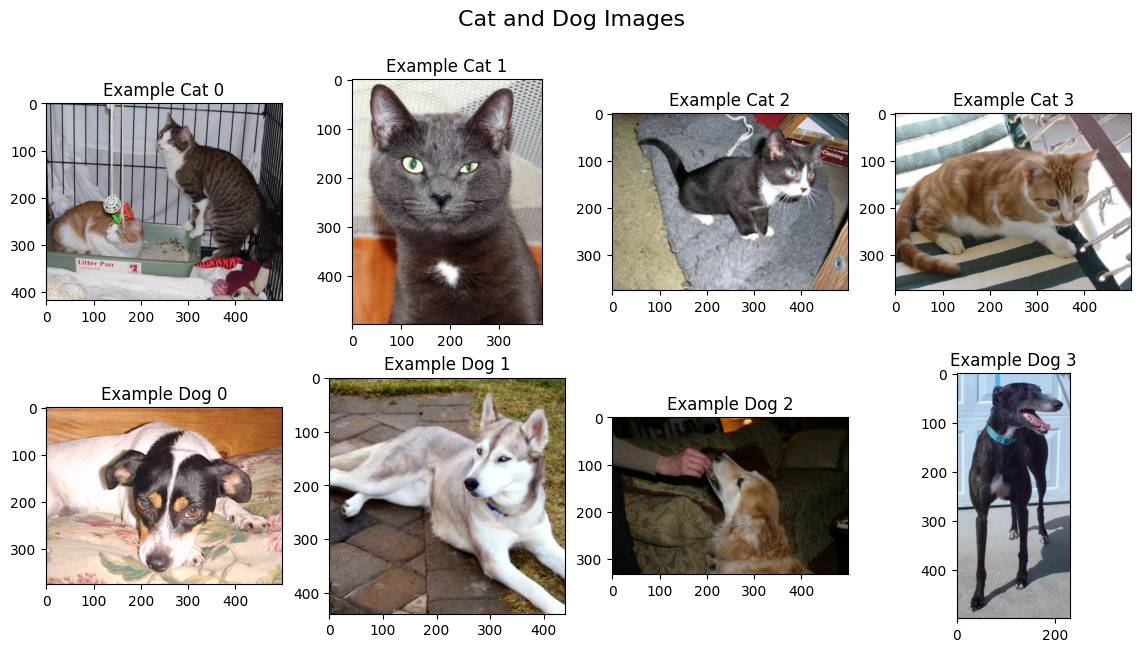

In [3]:
# Get the filenames for cats and dogs names
cats_filenames = [os.path.join(data_dir_cats,filename) for filename in os.listdir(data_dir_cats)]
dogs_filenames = [os.path.join(data_dir_dogs, filename) for filename in os.listdir(data_dir_dogs)]

fig , axes = plt.subplots(2,4, figsize=(14,7))
fig.suptitle('Cat and Dog Images', fontsize = 16)

for i , cat_image in enumerate(cats_filenames[:4]):
    img = tf.keras.utils.load_img(cat_image)
    axes[0,i].imshow(img)
    axes[0,i].set_title(f"Example Cat {i}")

for i , dog_image in enumerate(dogs_filenames[:4]):
    img = tf.keras.utils.load_img(dog_image)
    axes[1,i].imshow(img)
    axes[1,i].set_title(f"Example Dog {i}")

plt.show()

In [4]:
# train_val_datasets

def train_val_datasets():

    training_dataset,validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory = DATA_DIR,
        image_size = (150,150),
        batch_size = 128,
        label_mode = "binary",
        validation_split=0.10,
        subset ="both",
        seed=42,
        color_mode ="rgb"
    )
    return training_dataset,validation_dataset


In [5]:
# Create datasets
training_datasets, validation_datasets = train_val_datasets()

Found 22434 files belonging to 2 classes.
Using 20191 files for training.
Using 2243 files for validation.


I0000 00:00:1771486337.548429      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771486337.554471      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
# Get the first batch of images and labels

for images,labels in training_datasets.take(1):
    example_batch_images = images
    example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 150, 150, 3)
Shape of batch of labels: (128, 1)


In [7]:
def create_model():

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.Rescaling(1./255.),
        #Convolutions Layers
        tf.keras.layers.Conv2D(16,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the result to feef to DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001),
        loss="binary_crossentropy",
        metrics=['accuracy']
    )
    return model

In [8]:
model = create_model()


In [9]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs["accuracy"] >= 0.95 and logs["val_accuracy"] >= 0.8:
            self.model.stop_training = True
            print("\n Reached 95% train accuracy and 80% validation accuracy,so cancelling training!")

In [10]:
history = model.fit(
    training_datasets,
    epochs=15,
    validation_data = validation_datasets,
    callbacks =[EarlyStoppingCallback()]
)

Epoch 1/15


I0000 00:00:1771486342.564613      78 service.cc:152] XLA service 0x7b2720004650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771486342.564649      78 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771486342.564653      78 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771486342.975133      78 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-19 07:32:26.139545: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-19 07:32:26.288583: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  3/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5109 - loss: 1.5248 

I0000 00:00:1771486349.253796      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5498 - loss: 0.7732

2026-02-19 07:33:02.303412: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-19 07:33:02.449280: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - accuracy: 0.5504 - loss: 0.7720 - val_accuracy: 0.6875 - val_loss: 0.5789
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.6843 - loss: 0.5865 - val_accuracy: 0.7321 - val_loss: 0.5456
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.7448 - loss: 0.5136 - val_accuracy: 0.7673 - val_loss: 0.4789
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.7794 - loss: 0.4705 - val_accuracy: 0.7824 - val_loss: 0.4703
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.7951 - loss: 0.4289 - val_accuracy: 0.7914 - val_loss: 0.4396
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.8195 - loss: 0.4010 - val_accuracy: 0.8141 - val_loss: 0.4057
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.8381 - loss: 0.3579 - val_accuracy: 0.7882 - val_loss: 0.4759
Epoch 8/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.8611 - loss: 0.3155 - val

In [11]:
with open('history.pkl','wb') as f:
    pickle.dump(history.history, f)